## Les librairies


In [2]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from PIL import Image
from keras.utils import to_categorical
import cv2
import numpy as np
from fonctions import *

## Récupération des images et préparation de la dataset

In [3]:
# Chemin vers le dossier principal contenant les sous-dossiers

main_folder = '../MMU-Iris-Database/'
img_dim = (240, 320, 3)

Avec et sans normalisation des pixels

In [4]:
X_norm = []
y_norm = []

for target_folder in os.listdir(main_folder):
    
    target_path = os.path.join(main_folder, target_folder)
    
    if os.path.isdir(target_path):

        for side in ['left']:#, 'right']:

            side_path = os.path.join(target_path, side)

            if os.path.isdir(side_path):

                for image_filename in os.listdir(side_path):

                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):

                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image = preprocess_img_norm(cv2.imread(image_path), img_dim)
                        X_norm.append(image)
                        y_norm.append(target)  

X=[]
y=[]

for target_folder in os.listdir(main_folder):
    
    target_path = os.path.join(main_folder, target_folder)
    
    if os.path.isdir(target_path):

        for side in ['left']:#, 'right']:

            side_path = os.path.join(target_path, side)

            if os.path.isdir(side_path):

                for image_filename in os.listdir(side_path):

                    if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):

                        image_path = os.path.join(side_path, image_filename)
                        target = int(target_folder)
                        image = preprocess_img_without_norm(cv2.imread(image_path))
                        X.append(image)
                        y.append(target)        

In [10]:
from sklearn import preprocessing

labelEncNorm = preprocessing.LabelEncoder()
y_norm_enc = labelEnc.fit_transform(y_norm)

In [11]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets while maintaining class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size = 0.2, random_state = 42, stratify = y)

y_train_enc = to_categorical(y_train)
y_test_enc = to_categorical(y_test)

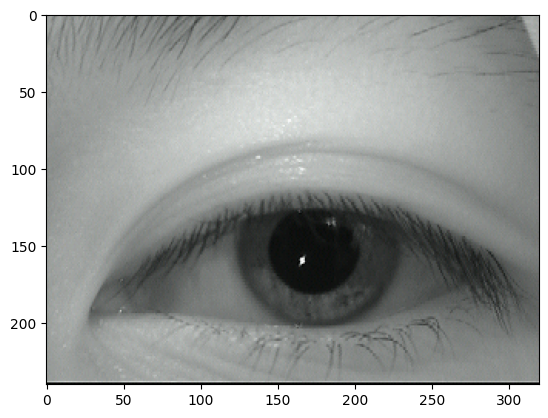

In [12]:
plt.imshow(X_train[0])

## Entrainement du modèle et affichage des performances

In [13]:
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

In [14]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten

NBCLASSES = 45
IMSIZE=[240,320]

def create_model():

    vgg = VGG16(input_shape = IMSIZE + [3], weights = 'imagenet', include_top = False)
 
    # Freeze existing VGG already trained weights 

    for layer in vgg.layers:

        layer.trainable = False
     
    # get the VGG output
    out = vgg.output
    
    # Add new dense layer at the end
    x = Flatten()(out)
    x = Dense(NBCLASSES, activation='softmax')(x)
     
    model = Model(inputs=vgg.input, outputs=x)
     
    model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])
     
    model.summary()
     
    return model
 
OG_model = create_model()
OG_model_norm = create_model()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 320, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 120, 160, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 120, 160, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 60, 80, 128)       0     

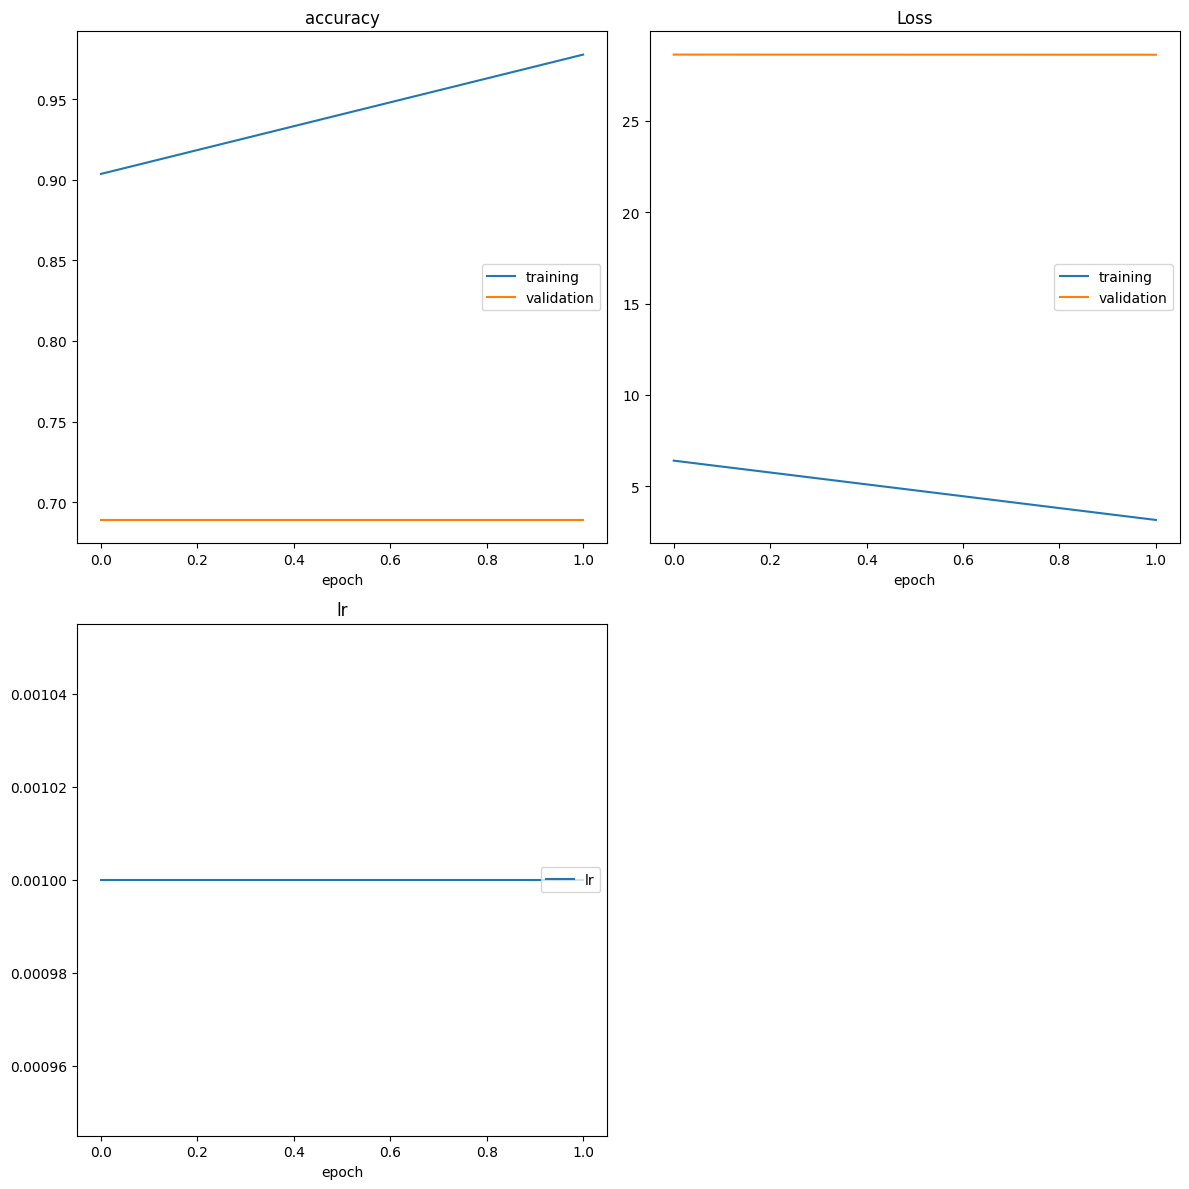

accuracy
	training         	 (min:    0.904, max:    0.978, cur:    0.978)
	validation       	 (min:    0.689, max:    0.689, cur:    0.689)
Loss
	training         	 (min:    3.152, max:    6.400, cur:    3.152)
	validation       	 (min:   28.618, max:   28.625, cur:   28.618)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
5/5 [==============================] - 98s 21s/step - loss: 3.1525 - accuracy: 0.9778 - val_loss: 28.6178 - val_accuracy: 0.6889 - lr: 0.0010


In [56]:
hist = OG_model.fit(np.array(X_train), np.array(y_train_enc), batch_size = 30, epochs = 2, validation_split = 0.25, callbacks = [rlrop, early, PlotLossesKeras()])

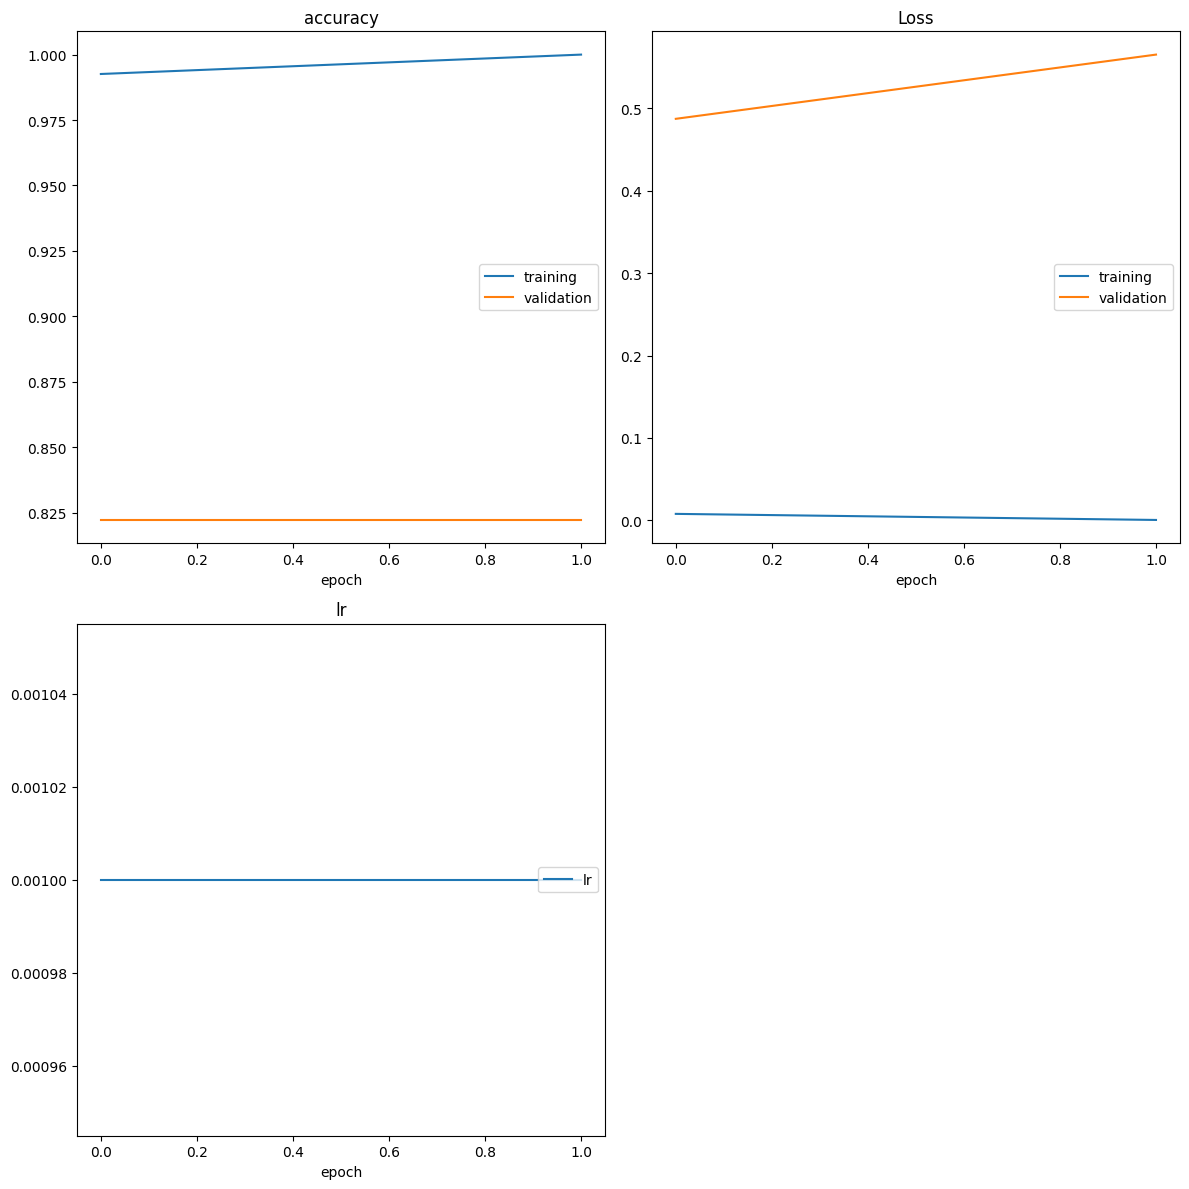

accuracy
	training         	 (min:    0.993, max:    1.000, cur:    1.000)
	validation       	 (min:    0.822, max:    0.822, cur:    0.822)
Loss
	training         	 (min:    0.000, max:    0.008, cur:    0.000)
	validation       	 (min:    0.487, max:    0.565, cur:    0.565)
lr
	lr               	 (min:    0.001, max:    0.001, cur:    0.001)
5/5 [==============================] - 92s 19s/step - loss: 4.9082e-04 - accuracy: 1.0000 - val_loss: 0.5651 - val_accuracy: 0.8222 - lr: 0.0010


In [57]:
hist = OG_model_norm.fit(np.array(X_train_norm), np.array(y_train_norm_enc), batch_size = 30, epochs = 2, validation_split = 0.25, callbacks = [rlrop, early, PlotLossesKeras()])

In [58]:
# Exemple de données de test (remplacez cela par vos propres données)

y_test_pred = [np.argmax(v) for v in OG_model.predict(np.array(X_test))]  # Prédictions du modèle
y_test_norm_pred = [np.argmax(v) for v in OG_model_norm.predict(np.array(X_test_norm))]  # Prédictions du modèle

2/2 [==============================] - 26s 9s/step


c:\vscode\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\vscode\venv\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Matrice de confusion :
Précision : 0.66
Rappel : 0.76
Score F1 : 0.69
Exactitude : 0.76
Matrice de confusion pour le modèle entrainé avec les données normalisées:
Précision : 0.86
Rappel : 0.89
Score F1 : 0.86
Exactitude : 0.89
[[1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]


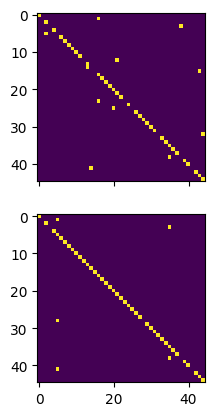

In [59]:
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(np.array(y_test), np.array(y_test_pred))
conf_matrix_norm = confusion_matrix(np.array(y_test_norm), np.array(y_test_norm_pred))

# Calcul des mesures de performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred,average='macro')
recall = recall_score(y_test, y_test_pred,average='macro')
f1 = f1_score(y_test, y_test_pred,average='macro')

accuracy_norm = accuracy_score(y_test_norm, y_test_norm_pred)
precision_norm = precision_score(y_test_norm, y_test_norm_pred,average='macro')
recall_norm = recall_score(y_test_norm, y_test_norm_pred,average='macro')
f1_norm = f1_score(y_test_norm, y_test_norm_pred,average='macro')

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True)

print("Matrice de confusion :")
ax1.imshow(conf_matrix)
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))
print("Exactitude : {:.2f}".format(accuracy))

print("Matrice de confusion pour le modèle entrainé avec les données normalisées:")
ax2.imshow(conf_matrix_norm)
print("Précision : {:.2f}".format(precision_norm))
print("Rappel : {:.2f}".format(recall_norm))
print("Score F1 : {:.2f}".format(f1_norm))
print("Exactitude : {:.2f}".format(accuracy_norm))
print(conf_matrix_norm)